In [173]:
import importlib
import sys, os

In [1]:
import numpy as np
import scipy.linalg as spl

In [160]:
import matplotlib.pyplot as plt
from matplotlib import rc
rc('text', usetex=True)

In [169]:
sys.path.insert(1, '..')
import grad_utils as model
import opt_utils
import cv_utils

# load data

In [7]:
data = np.load('simulation_data.npy')
latent = np.load('simulation_latent.npy')

In [8]:
data.shape, latent.shape

((10, 20, 20), (10, 20))

In [72]:
def PGD_l2_sq(data, lambda_smooth, beta_init=None,
              max_iter=1000, ths=1e-12, 
              step_size=0.1, max_back=100, a=0.2, b=0.5,
              verbose=False):
    # intiialize optimization
    if beta_init is None:
        beta = np.zeros(data.shape[:2])
    else:
        beta = beta_init
    nll = model.neg_log_like(beta, data)

    # initialize record
    objective_wback = [opt_utils.objective_l2_sq(beta, data, lambda_smooth)]
    if verbose:
        print("initial objective value: %f"%objective_wback[-1])

    # iteration
    for i in range(max_iter):
        # compute gradient
        gradient = model.grad_nl(beta, data).reshape(beta.shape)

        # backtracking line search
        s = step_size
        for j in range(max_back):
            beta_new = opt_utils.prox_l2_sq(beta - s*gradient, s, lambda_smooth)
            beta_diff = beta_new - beta

            nll_new = model.neg_log_like(beta_new, data)
            nll_back = (nll + np.sum(gradient * beta_diff) 
                        + np.sum(np.square(beta_diff)) / (2*s))

            if nll_new <= nll_back:
                break
            s *= b

        # proximal gradient update
        beta = beta_new
        nll = nll_new

        # record objective value
        objective_wback.append(opt_utils.objective_l2_sq(beta, data, lambda_smooth))
        
        if verbose:
            print("%d-th PGD, objective value: %f"%(i+1, objective_wback[-1]))
        if objective_wback[-2] - objective_wback[-1] < ths:
            if verbose:
                print("Converged!")
            break

    if i >= max_iter:
        if verbose:
            print("Not converged.")
    
    return beta, objective_wback

In [146]:
# optimization parameters
lambdas_smooth = np.linspace(0, 4, 41)

In [147]:
betas = []
for lambda_smooth in lambdas_smooth:
    beta, objective_wback = PGD_l2_sq(data, lambda_smooth)
    betas.append(beta)

# LOOCV

In [155]:
num_loocv = 200

In [149]:
indices = np.array(np.where(np.full(data.shape, True))).T

In [150]:
cum_match = np.cumsum(data.flatten())

In [151]:
loglikes_loocv = np.zeros(lambdas_smooth.shape)
for i in range(num_loocv):
    data_loocv = data.copy()
    rand_match = np.random.randint(np.sum(data))
    rand_index = indices[np.min(np.where(cum_match >= rand_match)[0])]
    data_loocv[tuple(rand_index)] -= 1
    
    for j, lambda_smooth in enumerate(lambdas_smooth):
        beta_loocv, _ = PGD_l2_sq(data_loocv, lambda_smooth, beta_init = betas[j])
        loglikes_loocv[j] += beta_loocv[rand_index[0],rand_index[1]] \
               - np.log(np.exp(beta_loocv[rand_index[0],rand_index[1]])
                        + np.exp(beta_loocv[rand_index[0],rand_index[2]]))
        
    print("%d-th cv done"%(i+1))

1-th cv done
2-th cv done
3-th cv done
4-th cv done
5-th cv done
6-th cv done
7-th cv done
8-th cv done
9-th cv done
10-th cv done
11-th cv done
12-th cv done
13-th cv done
14-th cv done
15-th cv done
16-th cv done
17-th cv done
18-th cv done
19-th cv done
20-th cv done
21-th cv done
22-th cv done
23-th cv done
24-th cv done
25-th cv done
26-th cv done
27-th cv done
28-th cv done
29-th cv done
30-th cv done
31-th cv done
32-th cv done
33-th cv done
34-th cv done
35-th cv done
36-th cv done
37-th cv done
38-th cv done
39-th cv done
40-th cv done
41-th cv done
42-th cv done
43-th cv done
44-th cv done
45-th cv done
46-th cv done
47-th cv done
48-th cv done
49-th cv done
50-th cv done
51-th cv done
52-th cv done
53-th cv done
54-th cv done
55-th cv done
56-th cv done
57-th cv done
58-th cv done
59-th cv done
60-th cv done
61-th cv done
62-th cv done
63-th cv done
64-th cv done
65-th cv done
66-th cv done
67-th cv done
68-th cv done
69-th cv done
70-th cv done
71-th cv done
72-th cv done
7

Text(0, 0.5, 'averaged nll')

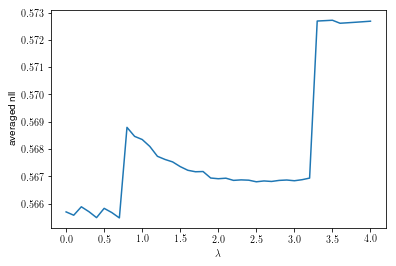

In [164]:
plt.plot(lambdas_smooth, -loglikes_loocv/num_loocv)
plt.xlabel(r'$\lambda$'); plt.ylabel(r"averaged nll")

In [168]:
np.argmax(loglikes_loocv), lambdas_smooth[np.argmax(loglikes_loocv)]

(7, 0.7000000000000001)

# cross-validated result

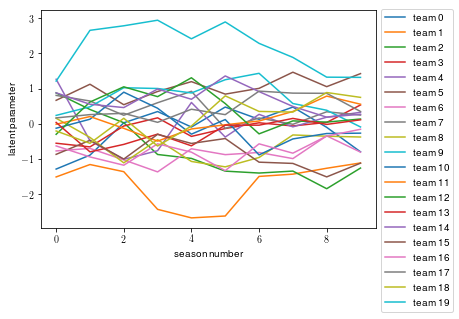

In [167]:
for i in range(beta.shape[1]):
    plt.plot(betas[7][:,i], label="team %d"%i)
plt.xlabel("season number")
plt.ylabel("latent parameter")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1.03, 1, 0))

# test cv_utils

In [176]:
lambda_cv, nll_cv, beta_cv = cv_utils.loocv(data, lambdas_smooth, PGD_l2_sq)

1-th cv done
2-th cv done
3-th cv done
4-th cv done
5-th cv done
6-th cv done
7-th cv done
8-th cv done
9-th cv done
10-th cv done
11-th cv done
12-th cv done
13-th cv done
14-th cv done
15-th cv done
16-th cv done
17-th cv done
18-th cv done
19-th cv done
20-th cv done
21-th cv done
22-th cv done
23-th cv done
24-th cv done
25-th cv done
26-th cv done
27-th cv done
28-th cv done
29-th cv done
30-th cv done
31-th cv done
32-th cv done
33-th cv done
34-th cv done
35-th cv done
36-th cv done
37-th cv done
38-th cv done
39-th cv done
40-th cv done
41-th cv done
42-th cv done
43-th cv done
44-th cv done
45-th cv done
46-th cv done
47-th cv done
48-th cv done
49-th cv done
50-th cv done
51-th cv done
52-th cv done
53-th cv done
54-th cv done
55-th cv done
56-th cv done
57-th cv done
58-th cv done
59-th cv done
60-th cv done
61-th cv done
62-th cv done
63-th cv done
64-th cv done
65-th cv done
66-th cv done
67-th cv done
68-th cv done
69-th cv done
70-th cv done
71-th cv done
72-th cv done
7

Text(0, 0.5, 'averaged nll')

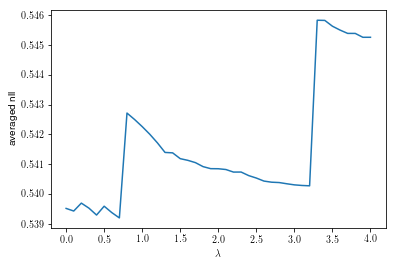

In [178]:
plt.plot(lambdas_smooth, nll_cv)
plt.xlabel(r'$\lambda$'); plt.ylabel(r"averaged nll")

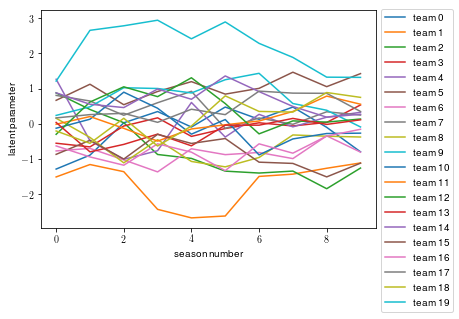

In [179]:
for i in range(beta.shape[1]):
    plt.plot(beta_cv[:,i], label="team %d"%i)
plt.xlabel("season number")
plt.ylabel("latent parameter")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1.03, 1, 0))